In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import nltk
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
import re
import pickle
import itertools
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
def prepare_text(text):
    def get_wordnet_pos(treebank_tag):
        mapping = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
        return mapping.get(treebank_tag[0], wordnet.NOUN)
    clean_text = re.sub(r'[^a-zA-Z\']', ' ', text)
    words = clean_text.split()
    tokens = word_tokenize(' '.join(words))
    pos_tags = pos_tag(tokens)
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [3]:
def vectorize_text(X):
    stopwords = set(nltk_stopwords.words('english'))
    vectorizer = TfidfVectorizer(stop_words=list(stopwords))
    X_vectorized = vectorizer.fit_transform(X)
    return X_vectorized, vectorizer  

In [4]:
data = pd.read_csv('./FinalBalancedDataset.csv')

In [5]:
data

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation
...,...,...,...
56740,56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,56741,1,"you've gone and broke the wrong heart baby, an..."
56742,56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,56743,1,youu got wild bitches tellin you lies


In [6]:
data.describe()

,Unnamed: 0,Toxicity
count,56745.00000,56745.000000
mean,28372.00000,0.425641
std,16381.01485,0.494444
min,0.00000,0.000000
25%,14186.00000,0.000000
50%,28372.00000,0.000000
75%,42558.00000,1.000000
max,56744.00000,1.000000


In [7]:
data['tweet'] = data['tweet'].apply(prepare_text)

In [8]:
X = data['tweet']
y = data["Toxicity"]

In [9]:
stopwords = set(nltk_stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words = list(stopwords))
X_vectorized = vectorizer.fit_transform(X)

In [10]:
def save_vectorizer(vectorizer):
    with open('vectorizer.pkl', 'wb') as file:
        pickle.dump(vectorizer, file)

In [11]:
save_vectorizer(vectorizer)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [13]:
def build_and_evaluate_model(model_type, X_train, y_train):
    if model_type == 'logistic':
        model = LogisticRegression(max_iter = 1000)
    elif model_type == 'random_forest':
        model = RandomForestClassifier()
    elif model_type == 'svm':
        model = SVC(probability = True)
    elif model_type == 'naive_bayes':
        model = MultinomialNB()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier()
    elif model_type == 'knn':
        model = KNeighborsClassifier()
    else:
        raise ValueError("Invalid model type. Choose from 'logistic', 'random_forest', 'svm', 'naive_bayes', 'decision_tree', 'knn'.")
    model.fit(X_train, y_train)
    return model


In [14]:
def save_model(model, model_type):
    filename = f'{model_type}_model.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

In [15]:
models = {}
metrics = []

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

for model_type in ['logistic', 'random_forest', 'naive_bayes', 'decision_tree', 'knn']:
    print(f"Applying {model_type}...")
    model = build_and_evaluate_model(model_type, X_train, y_train)
    models[model_type] = model
    
    save_model(model, model_type)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    logloss = log_loss(y_test, y_prob) if y_prob is not None else None

    metrics.append({
        'Model': model_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc,
        'Log Loss': logloss
    })
    
    print(f"Model: {model_type}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    if roc_auc is not None:
        print(f"ROC AUC Score: {roc_auc}")
    if logloss is not None:
        print(f"Log Loss: {logloss}")
    print('-' + '-'*30)

Applying logistic...
Model: logistic
Accuracy: 0.9339148823684906
Precision: 0.9615298590919258
Recall: 0.8814845191716218
F1 Score: 0.9197689345314506
ROC AUC Score: 0.982112865869994
Log Loss: 0.18877032557837703
-------------------------------
Applying random_forest...
Model: random_forest
Accuracy: 0.9372631949951538
Precision: 0.9357606193764386
Recall: 0.916957145786344
F1 Score: 0.9262634631317316
ROC AUC Score: 0.9811735821100178
Log Loss: 0.19911983437525155
-------------------------------
Applying naive_bayes...
Model: naive_bayes
Accuracy: 0.9154991629218433
Precision: 0.9079550187421908
Recall: 0.8939922083247899
F1 Score: 0.9009195164789751
ROC AUC Score: 0.9706487091727193
Log Loss: 0.26373494087746396
-------------------------------
Applying decision_tree...
Model: decision_tree
Accuracy: 0.934002995858666
Precision: 0.9282157676348548
Recall: 0.9173672339553004
F1 Score: 0.9227596163761989
ROC AUC Score: 0.9320100967103477
Log Loss: 2.348202889660719
-------------------

In [17]:
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

           Model  Accuracy  Precision    Recall  F1 Score  ROC AUC Score  \
0       logistic  0.933915   0.961530  0.881485  0.919769       0.982113   
1  random_forest  0.937263   0.935761  0.916957  0.926263       0.981174   
2    naive_bayes  0.915499   0.907955  0.893992  0.900920       0.970649   
3  decision_tree  0.934003   0.928216  0.917367  0.922760       0.932010   
4            knn  0.613887   0.923077  0.110724  0.197730       0.635420   

   Log Loss  
0  0.188770  
1  0.199120  
2  0.263735  
3  2.348203  
4  4.333806  


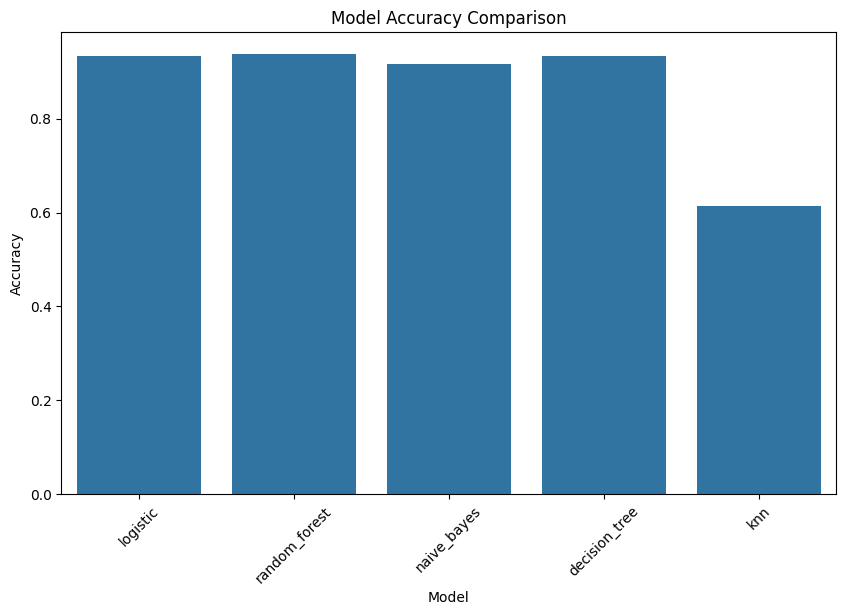

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

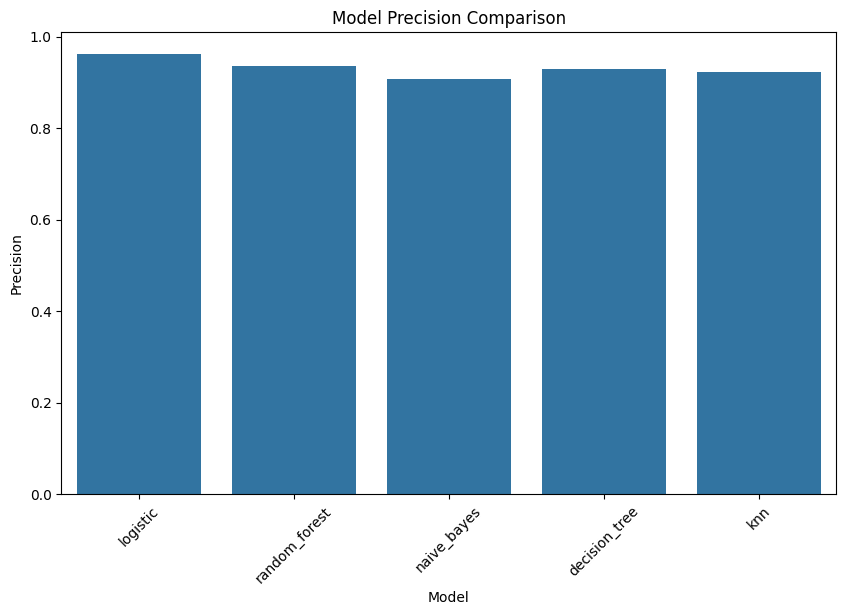

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=metrics_df)
plt.title('Model Precision Comparison')
plt.xticks(rotation=45)
plt.show()

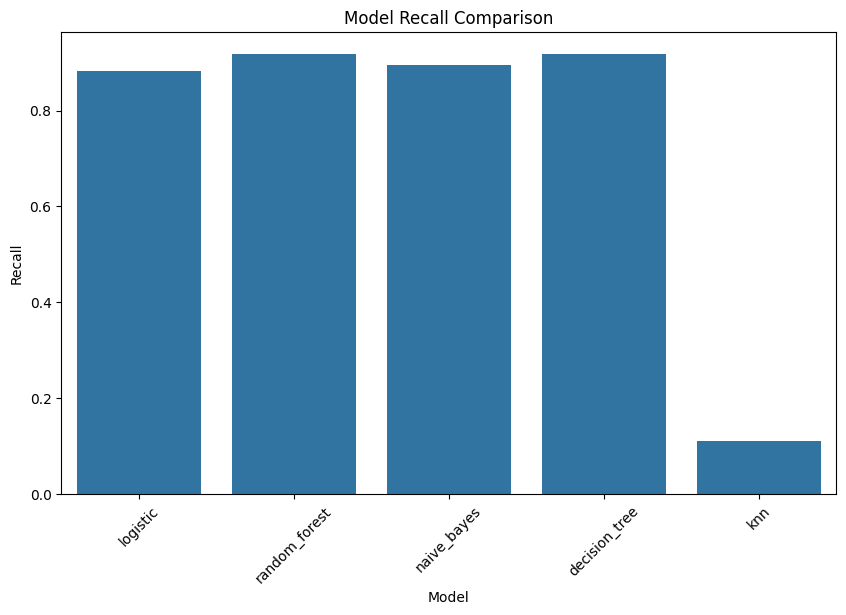

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=metrics_df)
plt.title('Model Recall Comparison')
plt.xticks(rotation=45)
plt.show()

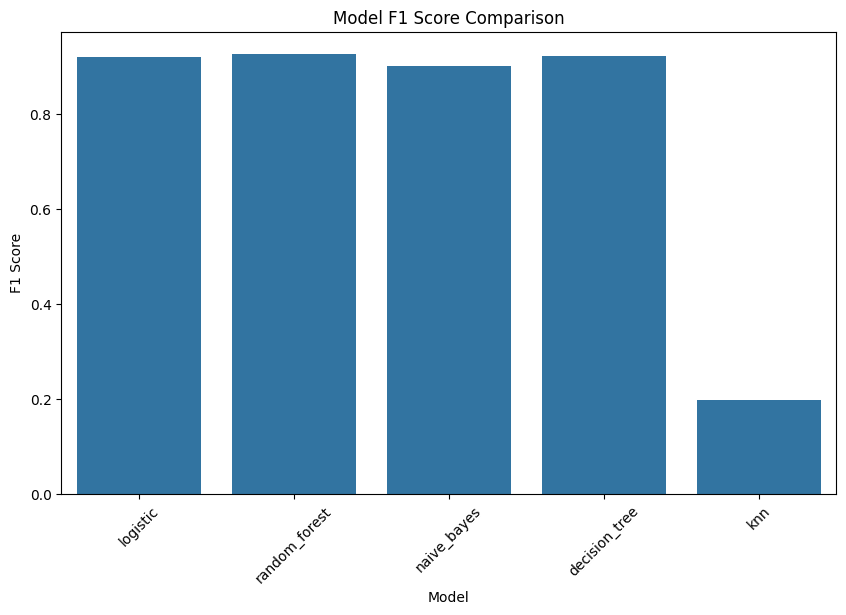

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score', data=metrics_df)
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)
plt.show()

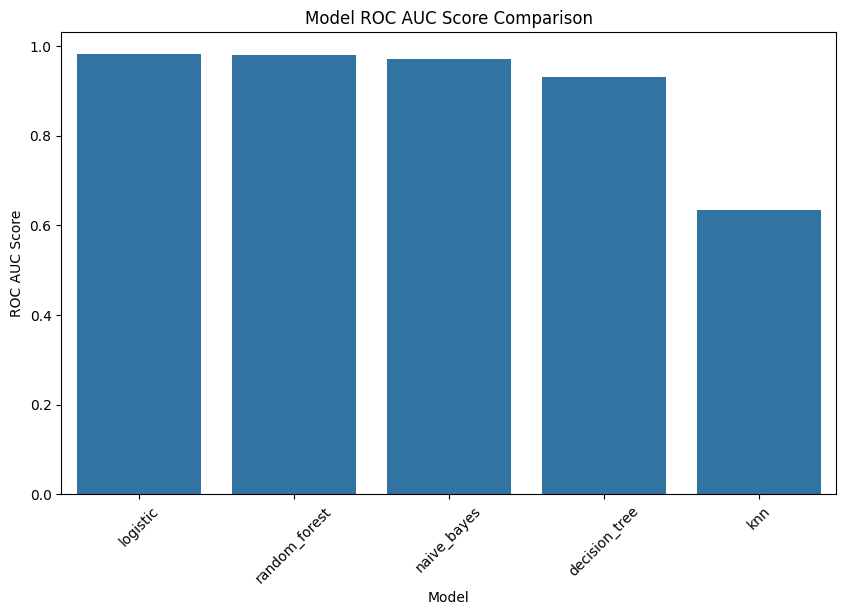

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC Score', data=metrics_df)
plt.title('Model ROC AUC Score Comparison')
plt.xticks(rotation=45)
plt.show()

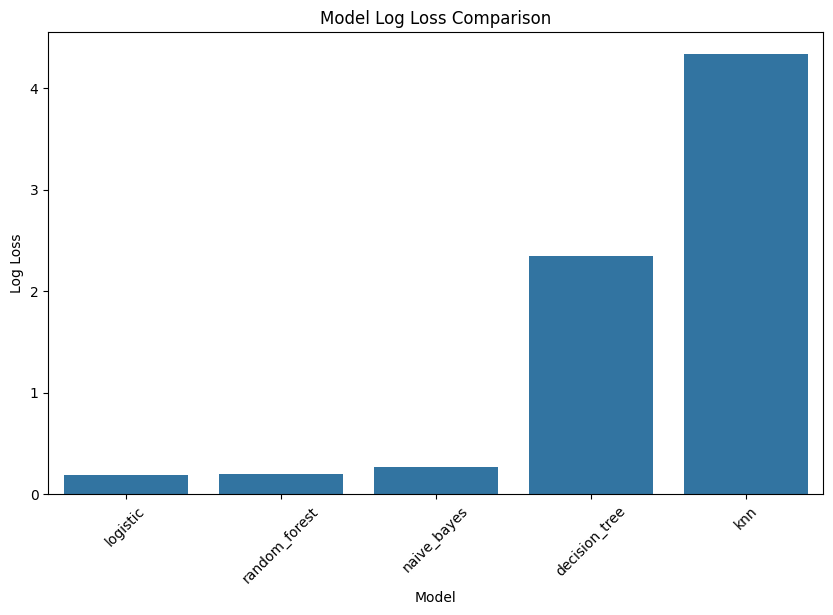

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Log Loss', data=metrics_df)
plt.title('Model Log Loss Comparison')
plt.xticks(rotation=45)
plt.show()

In [24]:
comment = "Salim"
processed_comment = prepare_text(comment)
vectorized_comment = vectorizer.transform([processed_comment])
predictions = {}

In [25]:
for model_type, model in models.items():
    if hasattr(model, "predict_proba"):
        prob = model.predict_proba(vectorized_comment)[:, 1]  
        pred = model.predict(vectorized_comment)[0]
    else:
        prob = None
        pred = model.predict(vectorized_comment)[0]
    
    predictions[model_type] = {
        'Predicted Class': pred,
        'Probability': prob[0] if prob is not None else "N/A"
    }

In [26]:
for model_type, result in predictions.items():
    print(f"Model: {model_type}")
    print(f"Predicted Class: {result['Predicted Class']}")
    print(f"Probability: {result['Probability']}")
    print('-' * 30)


Model: logistic
Predicted Class: 0
Probability: 0.19933096963097222
------------------------------
Model: random_forest
Predicted Class: 0
Probability: 0.17627908275934584
------------------------------
Model: naive_bayes
Predicted Class: 0
Probability: 0.4246189091549919
------------------------------
Model: decision_tree
Predicted Class: 0
Probability: 0.16666666666666666
------------------------------
Model: knn
Predicted Class: 0
Probability: 0.2
------------------------------
